# EXECUTE FROM TERMINAL
jupyter nbconvert --to notebook --ExecutePreprocessor.timeout=900  --execute FermiJagla.ipynb

In [44]:
import hoomd
import hoomd.md
import ex_render
import numpy as np
hoomd.context.initialize("--mode=cpu")

In [9]:
def jf(r, rmin, rmax, n, epsilon, a, A0, A1, A2, B0, B1, B2):
    V = epsilon * ( (a / r)**n + A0/(1 + np.exp(A1/A0*(r/a-A2))) - B0/(1 + np.exp(B1/B0*(r/a-B2))))
    F = epsilon * ( -n*(a / r)**n/r - A1*np.exp(A1/A0*(r/a-A2))/a/(1+np.exp(A1/A0*(r/a-A2)))**2 + 
                   B1*np.exp(B1/B0*(r/a-B2))/a/(1+np.exp(B1/B0*(r/a-B2)))**2)
    return (V, F)


unitcell=hoomd.lattice.sq(a=0.5, type_name='A')
hoomd.init.create_lattice(unitcell=unitcell, n=50)
nl = hoomd.md.nlist.cell()

table = hoomd.md.pair.table(width=1000, nlist=nl)
table.pair_coeff.set('A', 'A', func=jf, rmin=0.7, rmax=5.0, 
                     coeff=dict(n=20, epsilon=1.0, a=1.0, A0=4.56, A1=28.88, A2=1.36, B0=1.0, B1=3.57, B2=2.36))

all = hoomd.group.all();
d = hoomd.dump.gsd("md.gsd", period=1000, group=all, overwrite=True)
hoomd.md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.langevin(group=all, kT=1.2, seed=4)

notice(2): Group "all" created containing 2500 particles
notice(2): integrate.langevin/bd is using specified gamma values


In [10]:
print "Run simulation..."
hoomd.run(10e3)

Run simulation...
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 2500
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:11 | Step 136 / 10000 | TPS 13.5681 | ETA 00:12:07
Time 00:00:21 | Step 283 / 10000 | TPS 14.6176 | ETA 00:11:04
Time 00:00:31 | Step 434 / 10000 | TPS 15.0209 | ETA 00:10:36
Time 00:00:41 | Step 584 / 10000 | TPS 14.961 | ETA 00:10:29
Time 00:00:51 | Step 723 / 10000 | TPS 13.801 | ETA 00:11:12
Time 00:01:01 | Step 864 / 10000 | TPS 14.0639 | ETA 00:10:49
Time 00:01:11 | Step 1010 / 10000 | TPS 14.5291 | ETA 00:10:18
Time 00:01:21 | Step 1153 / 10000 | TPS 14.2565 | ETA 00:10:20
Time 00:01:31 | Step 1301 / 10000 | TPS 14.7476 | ETA 00:09:49
Time 00:01:41 | Step 1448 / 10000 | TPS 14.6865 | ETA 00:09:42
Time 00:01:51 | Step 1595 / 10000 | TPS 14.601 | ETA 00:09:35
Time 00:02:01 | Step 1735 / 10000 | TPS 13.976 | ETA 00:

In [45]:
tr = ex_render.get_trajectory("md_2.5.gsd")
print len(tr)

100


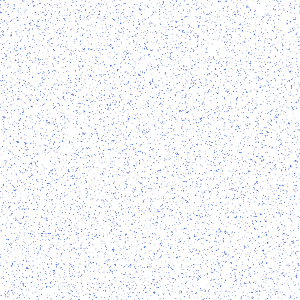

In [46]:
ex_render.render_disk_frame(tr[-1])

# COMPUTE 1D RDF

In [5]:
from freud import parallel, box, density
parallel.setNumThreads(4)
from bokeh.io import output_notebook
output_notebook()
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
import numpy as np

def default_bokeh(p):
    p.title.text_font_size = "18pt"
    p.title.align = "center"

    p.xaxis.axis_label_text_font_size = "14pt"
    p.yaxis.axis_label_text_font_size = "14pt"

    p.xaxis.major_tick_in = 10
    p.xaxis.major_tick_out = 0
    p.xaxis.minor_tick_in = 5
    p.xaxis.minor_tick_out = 0

    p.yaxis.major_tick_in = 10
    p.yaxis.major_tick_out = 0
    p.yaxis.minor_tick_in = 5
    p.yaxis.minor_tick_out = 0

    p.xaxis.major_label_text_font_size = "12pt"
    p.yaxis.major_label_text_font_size = "12pt"

Loading BokehJS ...

In [30]:
p_index = 0
tid = tr[0].particles.typeid == p_index
n_par = len(tr[0].particles.position[tid, 0])
p = np.zeros((n_par, 3), dtype=np.float32)
rdf = density.RDF(rmax=tr[0].configuration.box[0]/2, dr=0.1)
# compute the rdf for for all frames except the first (your syntax will vary based on your reader)
frame_begin = 90
frame_end = 100
frame_period = 10
# compute the rdf for for first frame
fbox = box.Box(Lx=tr[0].configuration.box[0], Ly=tr[0].configuration.box[1], is2D=True)
rdf.compute(fbox, p, p)
p[:, :] = tr[frame_begin].particles.position[tid, 0:3]
p[:, 2] = 0
for i in range(frame_begin, frame_end):
    # read box, position data
    if i % frame_period == 0:
        print "Frame #", i, " process"
    p[:, :] = tr[i].particles.position[tid, 0:3]
    p[:, 2] = 0
    # create the freud box object
    fbox = box.Box(Lx=tr[0].configuration.box[0], Ly=tr[0].configuration.box[1], is2D=True)
    # accumulate
    rdf.accumulate(fbox, p, p)

Frame # 90  process


In [31]:
# get the center of the histogram bins
r = rdf.getR()
# get the value of the histogram bins
y = rdf.getRDF()
# create bokeh plot
p = figure(title="RDF", x_axis_label='r', y_axis_label='g(r)')
p.line(r[0:100], y[0:100], legend="g(r)", line_width=2)
default_bokeh(p)
show(p)

# COMPUTE  $G_6(r)$

In [47]:
from freud import box, order
import numpy as np, math, random
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
import ex_render

def GetHexatic(frame_ind, rmax):
    # create hexatic object
    hex_order = order.HexOrderParameter(rmax=rmax, k=6, n=6);
    p_index = 0
    tid = tr[frame_ind].particles.typeid == p_index
    n_par = len(tr[frame_ind].particles.position[tid, 0])
    pos_data = np.zeros((n_par, 3), dtype=np.float32)
    # compute the hexatic order
    pos_data[:, :] = tr[frame_ind].particles.position[tid, 0:3]
    pos_data[:, 2] = 0
    ang_data = 2*np.arctan2(np.copy(tr[frame_ind].particles.orientation[tid,3]), 
                             np.copy(tr[frame_ind].particles.orientation[tid,0]))
    # create box
    fbox = box.Box(Lx=tr[0].configuration.box[0], Ly=tr[0].configuration.box[1], is2D=True)
    # compute hexatic order for 6 nearest neighbors
    hex_order.compute(fbox, pos_data)
    # get values from freud object
    psi_k = hex_order.getPsi()
    avg_psi_k = np.mean(psi_k)
    return (psi_k, avg_psi_k, ang_data, pos_data)

def GetHexaticObj(frame_ind, rmax):
    # create hexatic object
    hex_order = order.HexOrderParameter(rmax=rmax, k=6, n=6);
    p_index = 0
    tid = tr[frame_ind].particles.typeid == p_index
    n_par = len(tr[frame_ind].particles.position[tid, 0])
    pos_data = np.zeros((n_par, 3), dtype=np.float32)
    # compute the hexatic order
    pos_data[:, :] = tr[frame_ind].particles.position[tid, 0:3]
    pos_data[:, 2] = 0
    ang_data = 2*np.arctan2(np.copy(tr[frame_ind].particles.orientation[tid,3]), 
                             np.copy(tr[frame_ind].particles.orientation[tid,0]))
    # create box
    fbox = box.Box(Lx=tr[0].configuration.box[0], Ly=tr[0].configuration.box[1], is2D=True)
    # compute hexatic order for 6 nearest neighbors
    hex_order.compute(fbox, pos_data)
    return hex_order

In [73]:
data = GetHexatic(-1, 2)
psi_k = data[0]
avg_psi_k = data[1]
ang_data = data[2]
pos_data = data[3]
g6ij_mas = np.real(np.outer(psi_k, np.conj(psi_k)))
rij_mas = distance_matrix(pos_data[:, 0:2], pos_data[:, 0:2])
dr = 0.4
r_mas = []
g6_mas = []
for r in np.linspace(0.1, 2.5, 100):
    inds = (rij_mas > r - dr)*(rij_mas < r + dr)*(rij_mas > 0.0)
    g6_mas.append(np.mean(g6ij_mas[inds]))
    r_mas.append(r)
g6_mas = np.abs(np.array(g6_mas))
r_mas = np.array(r_mas)

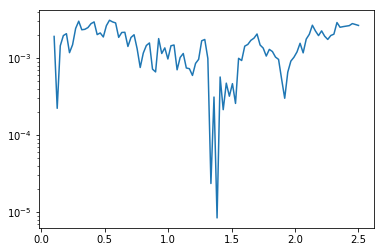

In [72]:
plt.semilogy(r_mas, g6_mas)
plt.show()